# Predicting marginal electricity generation from power plants in ERCOT

## Introduction
This report describes the process and results of a data science project to predict increases or decreases in electricity generation at fossil power plants in Texas. It begins with data collection and processing, and shows how the data are combined. The data fall into two general groups: 1) average operating characteristics of power plants over the course of a year, and 2) the state of the ERCOT grid at a given point in time ($t$) and the hour directly preceding $t$. We use the first set of data to group power plants into clusters, and the second set of data to predict the behavior of each cluster.

## Index
- [Background](#Background)  
- [Data collection](#Data-collection)  
- [Data cleaning/merging](#Data-cleaning/merging)  
    - [ERCOT data](#ERCOT-data)  
    - [EIA data](#EIA-data)  
        - [Power plant generation and fuel data from EIA-923](#Power-plant-generation-and-fuel-data-from-EIA-923)  
        - [Power plant capacity from EIA-860](#Power-plant-capacity-from-EIA-860)  
    - [EPA data](#EPA-data)  
- [Merging data for clustering](#Merging-data-for-clustering)  
- [Clustering](#Clustering)
- [Merge data for model](#Merge-data-for-model)  
- [Model training](#Model-training)

## Background
Most dispatchable electricity - electricity that can be produced on-demand - in the U.S. is generated at fossil power plants[[1]](#References). The plant, or plants, that generate more electricity in response to increased demand are called marginal generating units (MGUs). Models that predict MGUs generally fall into one of two categories: regression-based or unit-commitment economic dispatch[[2]](#References). The first category can account for effects (e.g. imperfect information) that are ignored in the second by examining real-world behavior. However, models that simply regress on historical behavior are ill-suited to making predictions about future grid conditions that differ from the data they were trained on. Applying machine learning techniques to energy sector analyses represents a pathway for potential improvements in the prediction of MGU behavior, and understanding the environmental impacts of energy transitions. This area of research is especially important as researchers and policy makers try to predict the economic and environmental impacts of vehicle electrification, demand-response management, and large scale deployment of variable renewable generating sources like wind and solar.


The goal of this project is to build a model that can predict the type of fossil MGU that will provide electricity for additional demand when given the current set of grid conditions. This type of problem can be difficult to solve, especially when the model is also trying to predict grid conditions like demand or wind generation. We are simplifying the model by treating these inputs as exogenous - the time of day or day of the year doesn't matter.

Predicting which individual power plant will provide marginal generation under a given set of grid conditions is also difficult. Individual facilities might go down for maintanence or otherwise not respond to changing grid conditions in an expected manner. We group individual fossil power plants based on their historical operating characteristics (average heat rate, capacity, capacity factor, and 95th percentile 1-hour ramp rate) using k-means clustering. The model treats each group as a single generating unit, and predicts it's change in generation given a change in grid demand.

## Import Libraries

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import glob
import re
import cPickle as pickle
import gzip
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR, LinearSVR
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor

/Users/Home/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Data collection
Our dataset covers 9 years of operation in the ERCOT power grid, which covers most of Texas. Data sources include:

- ERCOT [[3]](#References)
    - Hourly demand for power in Megawatts (MW)
    - Hourly generation of wind power and total installed capacity (MW)
- Energy Information Agency (EIA)
    - Annual generation for each power plant (MWh) and fuels used for generation [[4]](#References)
    - Capacity of each power plant in a given year (MW) [[5]](#References)
    - Monthly natural gas prices for electric customers in Texas [[6]](#References)
    - Quarterly coal prices for electric consumers in Texas [[7]](#References)
- Environmental Protection Agency (EPA)
    - Hourly gross generation at fossil-fuel power plants larger than 25 MW [[8]](#References)

All datasets were downloaded as Excel or CSV files. All of the raw data files combined are larger than 1 GB, and can be found on the [GitHub repository](https://github.com/gschivley/ERCOT_power) for this project.

## Data cleaning/merging
Because the datasets in this project came from a number of different sources and are given on a wide range of time scales, each had to be loaded, cleaned, and put in the correct form before they could all be merged.

### ERCOT data
ERCOT hourly data on demand (load), wind generation, and wind capacity can be downloaded for a full year in a single Excel file. File extensions include both .xls and .xlsx. The 9 files did not have consistent column names across all years. Changes were made by hand in Excel.

In [2]:
# Set up all the file paths, and column names to keep.

path = '../Raw Data/ERCOT/Hourly wind generation'
full_xls = os.path.join(path, '*.xls')
full_xlsx = os.path.join(path, '*.xlsx')

files = glob.glob(full_xls)
files.extend(glob.glob(full_xlsx))

In [3]:
cols = ['ERCOT Load, MW', 'Total Wind Installed, MW',
       'Total Wind Output, MW', 'Wind Output, % of Installed',
       'Wind Output, % of Load', '1-hr MW change', '1-hr % change']

Read the excel files, combine them into a single dataframe, and only keep the columns we need.

In [4]:
ercot = pd.concat([pd.read_excel(fn, sn='numbers', index_col=0) for fn in files])
ercot = ercot.loc[:,cols]
ercot.sort_index(inplace=True)
ercot = ercot.iloc[:-1,:]

Create a few plots to ensure the data looks good.

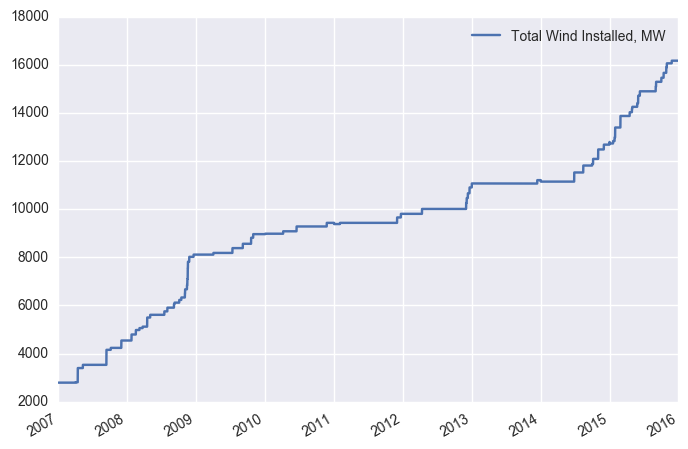

In [5]:
ercot.plot(y='Total Wind Installed, MW', use_index=True)

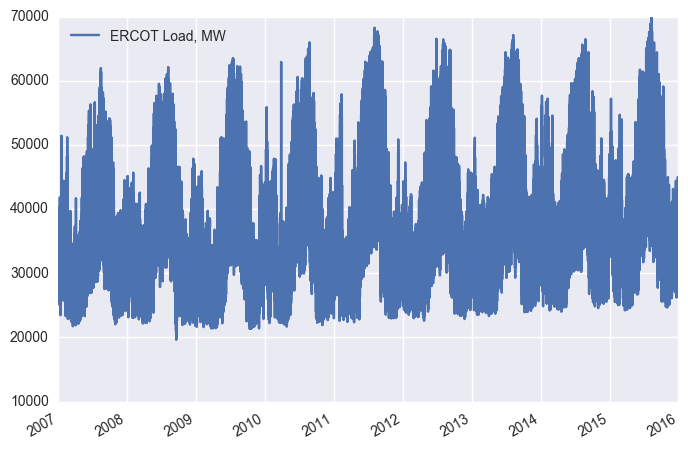

In [6]:
ercot.plot(y='ERCOT Load, MW', use_index=True)

In [7]:
ercot.head()

,"ERCOT Load, MW","Total Wind Installed, MW","Total Wind Output, MW","Wind Output, % of Installed","Wind Output, % of Load",1-hr MW change,1-hr % change
2007-01-01 00:00:00,30428.0,2790.0,1074.0,38.494624,3.529644,NaN,NaN
2007-01-01 01:00:00,30133.0,2790.0,922.6,33.068100,3.061760,-151.4,-14.096834
2007-01-01 02:00:00,29941.0,2790.0,849.2,30.437276,2.836245,-73.4,-7.955777
2007-01-01 03:00:00,29949.0,2790.0,1056.3,37.860215,3.526996,207.1,24.387659
2007-01-01 04:00:00,30248.0,2790.0,837.1,30.003584,2.767456,-219.2,-20.751680


In [8]:
ercot.loc[:,'Net Load (MW)'] = ercot.loc[:,'ERCOT Load, MW'] - ercot.loc[:,'Total Wind Output, MW']
ercot.loc[1:,'Net Load Change (MW)'] = ercot.iloc[1:,-1].values - ercot.iloc[:-1,-1].values
ercot.loc[:,'DATETIME'] = pd.to_datetime(ercot.index)

In [11]:
ercot.head()

,"ERCOT Load, MW","Total Wind Installed, MW","Total Wind Output, MW","Wind Output, % of Installed","Wind Output, % of Load",1-hr MW change,1-hr % change,Net Load (MW),Net Load Change (MW),DATETIME
2007-01-01 00:00:00,30428.0,2790.0,1074.0,38.494624,3.529644,NaN,NaN,29354.0,NaN,2007-01-01 00:00:00
2007-01-01 01:00:00,30133.0,2790.0,922.6,33.068100,3.061760,-151.4,-14.096834,29210.4,-143.6,2007-01-01 01:00:00
2007-01-01 02:00:00,29941.0,2790.0,849.2,30.437276,2.836245,-73.4,-7.955777,29091.8,-118.6,2007-01-01 02:00:00
2007-01-01 03:00:00,29949.0,2790.0,1056.3,37.860215,3.526996,207.1,24.387659,28892.7,-199.1,2007-01-01 03:00:00
2007-01-01 04:00:00,30248.0,2790.0,837.1,30.003584,2.767456,-219.2,-20.751680,29410.9,518.2,2007-01-01 04:00:00


Export Dataframe to csv and reload to avoid pre-processing of data

In [12]:
# filename = 'Ercot_Data.csv'
# fullpath = os.path.join(filename)
# ercot.to_csv(fullpath)

In [2]:
filename = 'Ercot_Data.csv'
fullpath = os.path.join(filename)

ercot = pd.read_csv(fullpath, index_col=0)

In [3]:
ercot.loc[:,'DATETIME'] = pd.to_datetime(ercot.index)

In [4]:
ercot.head()

,"ERCOT Load, MW","Total Wind Installed, MW","Total Wind Output, MW","Wind Output, % of Installed","Wind Output, % of Load",1-hr MW change,1-hr % change,Net Load (MW),Net Load Change (MW),DATETIME
2007-01-01 00:00:00,30428.0,2790.0,1074.0,38.494624,3.529644,NaN,NaN,29354.0,NaN,2007-01-01 00:00:00
2007-01-01 01:00:00,30133.0,2790.0,922.6,33.068100,3.061760,-151.4,-14.096834,29210.4,-143.6,2007-01-01 01:00:00
2007-01-01 02:00:00,29941.0,2790.0,849.2,30.437276,2.836245,-73.4,-7.955777,29091.8,-118.6,2007-01-01 02:00:00
2007-01-01 03:00:00,29949.0,2790.0,1056.3,37.860215,3.526996,207.1,24.387659,28892.7,-199.1,2007-01-01 03:00:00
2007-01-01 04:00:00,30248.0,2790.0,837.1,30.003584,2.767456,-219.2,-20.751680,29410.9,518.2,2007-01-01 04:00:00


### EIA data
We use EIA data for information about power plants and fuel prices.

#### Power plant generation and fuel data from EIA-923

In [11]:
#Iterate through the directory to find all the files to import
path = os.path.join('../Raw Data/EIA Data', '923-No_Header')
full_path = os.path.join(path, '*.*')

eiaNames = os.listdir(path)

#Rename the keys for easier merging later
fileNameMap = {'EIA923 SCHEDULES 2_3_4_5 Final 2010.xls':2010,
                'EIA923 SCHEDULES 2_3_4_5 M Final 2009 REVISED 05252011.XLS':2009,
                'eia923December2008.xls':2008,
                'EIA923_Schedules_2_3_4_5_2011_Final_Revision.xlsx':2011,
                'EIA923_Schedules_2_3_4_5_2012_Final_Release_12.04.2013.xlsx':2012,
                'EIA923_Schedules_2_3_4_5_2013_Final_Revision.xlsx':2013,
                'EIA923_Schedules_2_3_4_5_M_12_2014_Final_Revision.xlsx':2014,
                'EIA923_Schedules_2_3_4_5_M_12_2015_Final.xlsx':2015,
                'f906920_2007.xls':2007}

#Load the files into data frames, one df per file
eiaDict = {fileNameMap[fn]:pd.read_excel(os.path.join(path, fn)) for fn in eiaNames}
eiaDict = {key:val[val["NERC Region"] == "TRE"] for key, val in eiaDict.iteritems()}

In [12]:
#Dict of values to replace to standardize column names across all dataframes
monthDict = {"JANUARY":"JAN",
           "FEBRUARY":"FEB",
           "MARCH":"MAR",
           "APRIL":"APR",
           "MAY":"MAY",
           "JUNE":"JUN",
           "JULY":"JUL",
           "AUGUST":"AUG",
           "SEPTEMBER":"SEP",
           "OCTOBER":"OCT",
           "NOVEMBER":"NOV",
           "DECEMBER":"DEC"}
           
replaceDict = {"ELECTRIC":"ELEC",
               "&":"AND",
               "I.D.":"ID",
               "MMBTUPER":"MMBTU_PER"}
               
for month in monthDict.values():
    replaceDict["MMBTU"+month] = "MMBTU_" + month

#Replace the column name
def rename(col):
    for old, new in monthDict.iteritems():
        col = col.replace(old, new)
        
    for old, new in replaceDict.iteritems():
        col = col.replace(old, new)
        
    col = col.replace("MMBTUS", "MMBTU")
    return col
    
#Iterate through each column name of each dataframe to standardize
for key, df in eiaDict.iteritems():
    colNames = [name.replace("\n", "_").replace(" ", "_").strip().upper() for name in df.columns]
    colNames = [rename(col) for col in colNames]
    eiaDict[key].columns = colNames

In [13]:
#Define the columns that are necessary but are not summable
allCols = eiaDict[fileNameMap.values()[0]].columns
nonSumCols = ["PLANT_ID", "PLANT_NAME", "YEAR"]

#Define the columns that contain the year's totals (Used to calc fuel type %)
yearCols = ["TOTAL_FUEL_CONSUMPTION_QUANTITY", "ELEC_FUEL_CONSUMPTION_QUANTITY",
            "TOTAL_FUEL_CONSUMPTION_MMBTU", "ELEC_FUEL_CONSUMPTION_MMBTU",
            "NET_GENERATION_(MEGAWATTHOURS)"]

#Define the columns that are necessary and summable
sumCols = []
sumCols.extend(yearCols)
# regex = re.compile(r"^ELEC_QUANTITY_.*")
# sumCols.extend([col for col in allCols if regex.search(col)])
regex = re.compile(r"^MMBTU_PER_UNIT_.*")
sumCols.extend([col for col in allCols if regex.search(col)])
regex = re.compile(r"^TOT_MMBTU_.*")
sumCols.extend([col for col in allCols if regex.search(col)])
regex = re.compile(r"^ELEC_MMBTUS_.*")
sumCols.extend([col for col in allCols if regex.search(col)])
regex = re.compile(r"^NETGEN_.*")
sumCols.extend([col for col in allCols if regex.search(col)])

In [14]:
#Get a list of all the different fuel type codes.
fuelTypes = []
fuelTypes.extend([fuelType for df in eiaDict.values() for fuelType in df["REPORTED_FUEL_TYPE_CODE"].tolist()])
fuelTypes = set(fuelTypes)

In [15]:
# EIA-923 splits out electricity generated at a power plant generating units 
# and the type of fuel. We are aggregating everything to the facility level and 
# assigning a single fuel type to the plant. This fuel type is used to filter out 
# non-fossil plants and for analysis of what types of power plants are in the clusters.

# The cell below has three parts to aggregate by facility and to calculate the 
# % of each type of fuel. This will take a few minutes to run.  

# The end result is aggEIADict.

#Actually calculate the % fuel type for each facility grouping
def calcPerc(group, aggGroup, fuelType, col):
    #Check to see if the facility has a record for the fuel type, and if the total column > 0
    if len(group[group["REPORTED_FUEL_TYPE_CODE"] == fuelType]) > 0 and aggGroup[col] > 0:
        #summing fuel type because a facility may have multiple plants with the same fuel type        
        return float((group[group["REPORTED_FUEL_TYPE_CODE"] == fuelType][col]).sum())/aggGroup[col] 
    else:
        return 0

#Perform the aggregation on facility level
def aggAndCalcPerc(group):
    aggGroup = group.iloc[0][nonSumCols] #Get the non-agg columns
    aggGroup = aggGroup.append(group[sumCols].sum())   #Aggregate the agg columns and append to non-agg
    percCols = {col + " %" + fuelType:calcPerc(group, aggGroup, fuelType, col) for col in yearCols for fuelType in fuelTypes}
    aggGroup = aggGroup.append(pd.Series(percCols))
    return aggGroup    

#Iterate through each dataframe to perform aggregation by facility
aggEIADict = dict()
for key, df in eiaDict.iteritems():
    gb = df.groupby(by="PLANT_ID")
    #aggGroup will be a list of panda series, each series representing a facility
    aggGroup = [aggAndCalcPerc(gb.get_group(group)) for group in gb.groups]
    aggEIADict[key] = pd.DataFrame(aggGroup)

In [16]:
# Save the aggEIADict file
filename = 'aggEIADict.pkl'
pickle.dump(aggEIADict, open(filename, 'wb'))

In [5]:
#Load the aggEIADict pickle file
aggEIADict = pickle.load(open('aggEIADict.pkl', 'rb'))

In [65]:
aggEIADict[2011].loc[:,['PLANT_ID',
                        'YEAR',
                        'ELEC_FUEL_CONSUMPTION_QUANTITY',
                        'NET_GENERATION_(MEGAWATTHOURS)']].describe()

,PLANT_ID,YEAR,ELEC_FUEL_CONSUMPTION_QUANTITY,NET_GENERATION_(MEGAWATTHOURS)
count,257.000000,257.0,2.570000e+02,2.570000e+02
mean,37607.171206,2011.0,5.100424e+06,1.394113e+06
std,24062.076481,0.0,8.983724e+06,2.975741e+06
min,127.000000,2011.0,0.000000e+00,-3.350000e+02
25%,6251.000000,2011.0,0.000000e+00,3.800400e+04
50%,55015.000000,2011.0,5.010020e+05,3.550230e+05
75%,56374.000000,2011.0,6.215908e+06,1.419693e+06
max,58080.000000,2011.0,6.304202e+07,2.036590e+07


**Combine all df's from the dict into one df**



In [17]:
#Concat all dataframes, reset the index, determine the primary fuel type for 
# each facility, filter to only include fossil power plants
all923 = pd.concat(aggEIADict)
all923.reset_index(drop=True, inplace=True)

In [18]:
def top_fuel(row):
    #Fraction of largest fuel for electric heat input 
    try:
        fuel = row.iloc[1:27].idxmax()[29:]
    except:
        return None
    return fuel

In [19]:
all923['FUEL'] = all923.apply(top_fuel, axis=1)

Because the EPA data only includes power plants that burn fossil fuels, we are only keeping these facilities. The codes below correspond to:
- Diesel fuel oil
- Lignite coal
- Natural gas
- Petroleum coke
- Subbituminous coal

In [20]:
fossil923 = all923.loc[all923['FUEL'].isin(['DFO', 'LIG', 'NG', 'PC', 'SUB'])]

In [21]:
fossil923.head()

,ELEC_FUEL_CONSUMPTION_MMBTU,ELEC_FUEL_CONSUMPTION_MMBTU %AB,ELEC_FUEL_CONSUMPTION_MMBTU %BIT,ELEC_FUEL_CONSUMPTION_MMBTU %BLQ,ELEC_FUEL_CONSUMPTION_MMBTU %DFO,ELEC_FUEL_CONSUMPTION_MMBTU %JF,ELEC_FUEL_CONSUMPTION_MMBTU %LFG,ELEC_FUEL_CONSUMPTION_MMBTU %LIG,ELEC_FUEL_CONSUMPTION_MMBTU %MWH,ELEC_FUEL_CONSUMPTION_MMBTU %NG,...,TOT_MMBTU_JAN,TOT_MMBTU_JUL,TOT_MMBTU_JUN,TOT_MMBTU_MAR,TOT_MMBTU_MAY,TOT_MMBTU_NOV,TOT_MMBTU_OCT,TOT_MMBTU_SEP,YEAR,FUEL
3,171279117.0,0.0,0.0,0.0,0.00082,0.0,0.0,0.403995,0.0,0.0,...,1.39678e+07,1.50848e+07,1.40674e+07,1.47215e+07,1.3538e+07,1.45648e+07,1.49483e+07,1.39296e+07,2007,SUB
11,11685020.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,1.0,...,1.34154e+06,939196,854170,755772,1.20999e+06,725064,1.00316e+06,1.04083e+06,2007,NG
12,157326.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,1.0,...,109526,140525,130156,108289,111163,91045,115127,136948,2007,NG
13,891411.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,1.0,...,230890,296241,274381,228286,234341,191932,242701,288700,2007,NG
14,19445694.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,1.0,...,2.0661e+06,2.02784e+06,2.52676e+06,951082,1.53421e+06,1.17530e+06,842856,1.09479e+06,2007,NG


#### Export the EIA 923 data dataframe as csv

In [25]:
filename = 'Fossil_EIA_923.csv'
fullpath = os.path.join(filename)
fossil923.to_csv(fullpath, index=None)

In [7]:
## Reload data from File to avoid running the data pre-processing steps:
filename = 'Fossil_EIA_923.csv'
fullpath = os.path.join(filename)
fossil923 = pd.read_csv(fullpath)

In [8]:
fossil923.head()

,ELEC_FUEL_CONSUMPTION_MMBTU,ELEC_FUEL_CONSUMPTION_MMBTU %AB,ELEC_FUEL_CONSUMPTION_MMBTU %BIT,ELEC_FUEL_CONSUMPTION_MMBTU %BLQ,ELEC_FUEL_CONSUMPTION_MMBTU %DFO,ELEC_FUEL_CONSUMPTION_MMBTU %JF,ELEC_FUEL_CONSUMPTION_MMBTU %LFG,ELEC_FUEL_CONSUMPTION_MMBTU %LIG,ELEC_FUEL_CONSUMPTION_MMBTU %MWH,ELEC_FUEL_CONSUMPTION_MMBTU %NG,...,TOT_MMBTU_JAN,TOT_MMBTU_JUL,TOT_MMBTU_JUN,TOT_MMBTU_MAR,TOT_MMBTU_MAY,TOT_MMBTU_NOV,TOT_MMBTU_OCT,TOT_MMBTU_SEP,YEAR,FUEL
0,171279117.0,0.0,0.0,0.0,0.00082,0.0,0.0,0.403995,0.0,0.0,...,13967820.0,15084781.0,14067444.0,14721451.0,13538027.0,14564808.0,14948266.0,13929609.0,2007,SUB
1,11685020.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,1.0,...,1341538.0,939196.0,854170.0,755772.0,1209990.0,725064.0,1003156.0,1040830.0,2007,NG
2,157326.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,1.0,...,109526.0,140525.0,130156.0,108289.0,111163.0,91045.0,115127.0,136948.0,2007,NG
3,891411.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,1.0,...,230890.0,296241.0,274381.0,228286.0,234341.0,191932.0,242701.0,288700.0,2007,NG
4,19445694.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.000000,0.0,1.0,...,2066098.0,2027836.0,2526761.0,951082.0,1534209.0,1175305.0,842856.0,1094786.0,2007,NG


#### Power plant capacity from EIA-860

In [22]:
# Iterate through the directory to find all the files to import
path = os.path.join('../Raw Data/EIA Data', '860-No_Header')
full_path = os.path.join(path, '*.*')

eia860Names = os.listdir(path)

# Rename the keys for easier merging later
fileName860Map = {  'GenY07.xls':2007,
                    'GenY08.xls':2008,
                    'GeneratorY09.xls':2009,
                    'GeneratorsY2010.xls':2010,
                    'GeneratorY2011.xlsx':2011,
                    'GeneratorY2012.xlsx':2012,
                    '3_1_Generator_Y2013.xlsx':2013,
                    '3_1_Generator_Y2014.xlsx':2014,
                    '3_1_Generator_Y2015.xlsx':2015}

#Load the files into data frames, one df per file
eia860Dict = {fileName860Map[fn]:pd.read_excel(os.path.join(path, fn)) for fn in eia860Names}  

In [23]:
#Dict of values to replace to standardize column names across all dataframes
renameDict = {  "PLNTCODE":"PLANT_ID",
                "PLANT_CODE":"PLANT_ID",
                "Plant Code":"PLANT_ID",
                "NAMEPLATE":"NAMEPLATE_CAPACITY(MW)",
                "Nameplate Capacity (MW)":"NAMEPLATE_CAPACITY(MW)"}

#Replace the column name
def rename860(col):
    for old, new in renameDict.iteritems():
        col = col.replace(old, new)
    return col

#Iterate through each column name of each dataframe to standardize and select columns 'PLANT_ID', 'NAMEPLATE_CAPACITY(MW)'
for key, df in eia860Dict.iteritems():
    colNames = [rename860(col) for col in df.columns]
    eia860Dict[key].columns = colNames
    eia860Dict[key] = eia860Dict[key][["PLANT_ID", "NAMEPLATE_CAPACITY(MW)"]]

In [24]:
# Power plants can include multiple generating units. We are aggregating the 
# total generating capacity of units in the EIA-860 database to the facility level.

# Iterate through each dataframe to perform aggregation by PLANT_ID
for key, df in eia860Dict.iteritems():
    gb = df.groupby(by='PLANT_ID').apply(lambda x: x['NAMEPLATE_CAPACITY(MW)'].sum())
    eia860Dict[key]['NAMEPLATE_CAPACITY(MW)'] = eia860Dict[key].PLANT_ID.apply(gb.get_value)
    eia860Dict[key] = eia860Dict[key].drop_duplicates(subset=['PLANT_ID', 'NAMEPLATE_CAPACITY(MW)'])
    eia860Dict[key] = eia860Dict[key].sort_values(by='PLANT_ID').reset_index(drop=True)

In [30]:
eia860Dict[2007].head()

,PLANT_ID,NAMEPLATE_CAPACITY(MW)
0,2,45.0
1,3,2671.4
2,4,225.0
3,7,138.0
4,8,1416.7


In [25]:
# Save the aggEIADict file
filename = 'eia860.pkl'
pickle.dump(eia860Dict, open(filename, 'wb'))

In [9]:
#Load the eia860Dict pickle file
eia860Dict = pickle.load(open('eia860.pkl', 'rb'))

In [10]:
eia860Dict[2010].head()

,PLANT_ID,NAMEPLATE_CAPACITY(MW)
0,2,45.0
1,3,2841.5
2,4,225.0
3,7,138.0
4,8,1416.7


### Fuel price data
EIA provides historical data on natural gas and coal prices for electric power customers in each state. We use data for power plants in Texas and assume that they are accurate for plants in ERCOT. Natural gas data is provided on a monthly basis. Coal data is available by type (lignite, subbituminous, and a combination of the two labeled “All coal”) on a quarterly basis, but only going back through 2008. Coal prices have not changed drastically over time so we make the assumption that prices in 2007 were equal to the average price in 2008.

#### Natural gas price


In [31]:
#The natural gas data are easy to process. We load the Excel file and add 
#columns for `Month` and `Year`. 
path = os.path.join('../Raw Data/EIA data', 'Natural gas price', 'N3045TX3m.xls')
ng_price = pd.read_excel(path, sheetname='Data 1', header=2)

In [32]:
ng_price.rename(columns={"Texas Natural Gas Price Sold to Electric Power Consumers (Dollars per Thousand Cubic Feet)":
                         "NG Price ($/mcf)"}, inplace=True)

In [33]:
ng_price.loc[:,'Month'] = ng_price.loc[:,'Date'].apply(lambda x: x.month)
ng_price.loc[:,'Year'] = ng_price.loc[:,'Date'].apply(lambda x: x.year)

In [34]:
ng_price.tail()

,Date,NG Price ($/mcf),Month,Year
170,2016-03-15,1.91,3,2016
171,2016-04-15,2.14,4,2016
172,2016-05-15,2.17,5,2016
173,2016-06-15,2.62,6,2016
174,2016-07-15,2.95,7,2016


#### Coal price
The coal price data require more work to load and get into a workable format.  We add columns for `Quarter` and `Year`, then merge with a separate dataframe with one date in each month of the 9 year period. Finally, this dataframe is merged with the natural gas price dataframe.

In [35]:
path = os.path.join('../Raw Data/EIA data', 'Coal prices', 'Texas electric sector coal price.xlsx')
coal_temp = pd.read_excel(path, sheetname='Sheet1')

In [36]:
coal_temp.loc[:,'Quarter'] = coal_temp.loc[:,'Date'].apply(lambda x: int(x[1]))
coal_temp.loc[:,'Year'] = coal_temp.loc[:,'Date'].apply(lambda x: int(x[-4:]))

In [37]:
coal_temp.head()

,Date,All coal,Lignite,Subbituminous,Quarter,Year
0,Q1 2008,24.32,19.38,26.72,1,2008
1,Q2 2008,24.94,19.36,28.21,2,2008
2,Q3 2008,25.91,20.11,29.23,3,2008
3,Q4 2008,25.42,21.26,28.30,4,2008
4,Q1 2009,25.92,22.40,27.88,1,2009


#### Make data for 2007

In [38]:
coal_2007 = pd.DataFrame(columns=coal_temp.columns)
coal_2007['Quarter'] = [1,2,3,4]
coal_2007['Year'] = 2007
for coal in ['All coal', 'Lignite', 'Subbituminous']:
    coal_2007[coal] = coal_temp.loc[coal_temp['Year']==2008,coal].mean()

In [39]:
coal_temp = coal_temp.append(coal_2007)

In [40]:
coal_temp.tail()

,Date,All coal,Lignite,Subbituminous,Quarter,Year
32,Q1 2016,26.4400,22.6100,31.430,1,2016
0,NaN,25.1475,20.0275,28.115,1,2007
1,NaN,25.1475,20.0275,28.115,2,2007
2,NaN,25.1475,20.0275,28.115,3,2007
3,NaN,25.1475,20.0275,28.115,4,2007


In [41]:
# Create a time dataframe grom 2007-2015
df = pd.DataFrame(pd.date_range('2007-1-15', periods=12*9, freq='M'), columns=['tempdate'])
df.loc[:,'Quarter'] = df.loc[:,'tempdate'].apply(lambda x: x.quarter)
df.loc[:,'Month'] = df.loc[:,'tempdate'].apply(lambda x: x.month)
df.loc[:,'Year'] = df.loc[:,'tempdate'].apply(lambda x: x.year)

In [42]:
coal_price = pd.merge(coal_temp, df, on=['Quarter', 'Year'])

In [43]:
coal_price.head()

,Date,All coal,Lignite,Subbituminous,Quarter,Year,tempdate,Month
0,Q1 2008,24.32,19.38,26.72,1,2008,2008-01-31,1
1,Q1 2008,24.32,19.38,26.72,1,2008,2008-02-29,2
2,Q1 2008,24.32,19.38,26.72,1,2008,2008-03-31,3
3,Q2 2008,24.94,19.36,28.21,2,2008,2008-04-30,4
4,Q2 2008,24.94,19.36,28.21,2,2008,2008-05-31,5


In [44]:
#Combine the natural gas and coal price dataframes.

fuel_price = pd.merge(ng_price, coal_price, how='right', on=['Month', 'Year'])
fuel_price.drop(['Date_x', 'Date_y', 'tempdate', 'Quarter'], axis=1, inplace=True)

In [48]:
fuel_price.head()

,NG Price ($/mcf),Month,Year,All coal,Lignite,Subbituminous
0,6.42,1,2007,25.1475,20.0275,28.115
1,7.34,2,2007,25.1475,20.0275,28.115
2,6.90,3,2007,25.1475,20.0275,28.115
3,7.29,4,2007,25.1475,20.0275,28.115
4,7.51,5,2007,25.1475,20.0275,28.115


In [46]:
#Save the dataframe to csv
filename = 'Fuel_Prices.csv'
fullpath = os.path.join(filename)
fuel_price.to_csv(fullpath, index=None)

In [11]:
## Reload data from File to avoid running the data pre-processing steps:
filename = 'Fuel_Prices.csv'
fullpath = os.path.join(filename)
fuel_price = pd.read_csv(fullpath)

In [16]:
fuel_price.head()

,NG Price ($/mcf),Month,Year,All coal,Lignite,Subbituminous
0,6.42,1,2007,25.1475,20.0275,28.115
1,7.34,2,2007,25.1475,20.0275,28.115
2,6.90,3,2007,25.1475,20.0275,28.115
3,7.29,4,2007,25.1475,20.0275,28.115
4,7.51,5,2007,25.1475,20.0275,28.115


### EPA data
EPA hourly data is stored in a series of .txt files that each cover a 6 month period.

In [38]:
#Read the EPA files into a dataframe
path2 = os.path.join('../Raw Data/EPA air markets')
epaNames = os.listdir(path2)
filePaths = {dn:os.path.join(path2, dn, "*.txt") for dn in epaNames}
filePaths = {dn:glob.glob(val) for dn, val in filePaths.iteritems()}
epaDict = {key:pd.read_csv(fp, index_col = False) for key, val in filePaths.iteritems() for fp in val}

The DataFrames in epaDict contain all power plants in Texas. We can filter on NERC REGION so that it only includes ERCOT.

In [39]:
#Rename the column names to remove the leading space.
for key, df in epaDict.iteritems():
    colNames = [name.upper().strip() for name in df.columns]
    colNames[colNames.index("FACILITY ID (ORISPL)")] = "PLANT_ID"
    epaDict[key].columns = colNames
    
#Convert DATE to datetime object
#Add new column DATETIME with both date and hour
for key, df in epaDict.iteritems():
    epaDict[key]["DATE"] = pd.to_datetime(df["DATE"])
    epaDict[key]['DATETIME'] = df['DATE'] + pd.to_timedelta(df['HOUR'], unit='h')

In [40]:
#Boolean filter to only keep ERCOT plants
for key, df in epaDict.iteritems():
    epaDict[key] = df[df["NERC REGION"] == "ERCOT"].reset_index(drop = True)

In [41]:
epaDict['2015 July-Dec'].head()

,STATE,FACILITY NAME,PLANT_ID,YEAR,DATE,HOUR,GROSS LOAD (MW),STEAM LOAD (1000LB/HR),SO2 (POUNDS),NOX (POUNDS),CO2 (SHORT TONS),EPA REGION,NERC REGION,COUNTY,HEAT INPUT (MMBTU),FACILITY LATITUDE,FACILITY LONGITUDE,DATETIME
0,TX,Barney M. Davis,4939,2015,2015-07-01,0,NaN,NaN,NaN,NaN,NaN,6,ERCOT,Nueces,NaN,27.6067,-97.3119,2015-07-01 00:00:00
1,TX,Barney M. Davis,4939,2015,2015-07-01,1,NaN,NaN,NaN,NaN,NaN,6,ERCOT,Nueces,NaN,27.6067,-97.3119,2015-07-01 01:00:00
2,TX,Barney M. Davis,4939,2015,2015-07-01,2,NaN,NaN,NaN,NaN,NaN,6,ERCOT,Nueces,NaN,27.6067,-97.3119,2015-07-01 02:00:00
3,TX,Barney M. Davis,4939,2015,2015-07-01,3,NaN,NaN,NaN,NaN,NaN,6,ERCOT,Nueces,NaN,27.6067,-97.3119,2015-07-01 03:00:00
4,TX,Barney M. Davis,4939,2015,2015-07-01,4,NaN,NaN,NaN,NaN,NaN,6,ERCOT,Nueces,NaN,27.6067,-97.3119,2015-07-01 04:00:00


In [34]:
allEPA = pd.concat(epaDict)

In [35]:
allEPA.fillna(0, inplace=True)

CO2 (SHORT TONS)  COUNTY       DATE            DATETIME  \
2007 Jan-June 0               0.0  Harris 2007-01-01 2007-01-01 00:00:00   
              1               0.0  Harris 2007-01-01 2007-01-01 01:00:00   
              2               0.0  Harris 2007-01-01 2007-01-01 02:00:00   
              3               0.0  Harris 2007-01-01 2007-01-01 03:00:00   
              4               0.0  Harris 2007-01-01 2007-01-01 04:00:00   

                 EPA REGION  FACILITY LATITUDE  FACILITY LONGITUDE  \
2007 Jan-June 0           6            29.7239            -95.2258   
              1           6            29.7239            -95.2258   
              2           6            29.7239            -95.2258   
              3           6            29.7239            -95.2258   
              4           6            29.7239            -95.2258   

                          FACILITY NAME  GROSS LOAD (MW)  HEAT INPUT (MMBTU)  \
2007 Jan-June 0  AES Western Power, LLC              0.0                 0.0   
              1  AES Western Power, LLC              0.0                 0.0   
              2  AES Western Power, LLC              0.0                 0.0   
              3  AES Western Power, LLC              0.0                 0.0   
              4  AES Western Power, LLC              0.0                 0.0   

                 HOUR NERC REGION  NOX (POUNDS)  PLANT_ID  SO2 (POUNDS) STATE  \
2007 Jan-June 0     0       ERCOT           0.0      3461           0.0    TX   
              1     1       ERCOT           0.0      3461           0.0    TX   
              2     2       ERCOT           0.0      3461           0.0    TX   
              3     3       ERCOT           0.0      3461           0.0    TX   
              4     4       ERCOT           0.0      3461           0.0    TX   

                 STEAM LOAD (1000LB/HR)  YEAR  
2007 Jan-June 0                     0.0  2007  
              1                     0.0  2007  
              2                     0.0  2007  
              3                     0.0  2007  
              4                     0.0  2007

In [36]:
def plant_gen_delta(df):
    """
    For every plant in the input df, calculate the change in gross load (MW)
    from the previous hour.
    
    input:
        df: dataframe of EPA clean air markets data
    return:
        df: concatanated list of dataframes
    """
    df_list = []
    for plant in df['PLANT_ID'].unique():
        temp = df.loc[df['PLANT_ID'] == plant,:]
        temp.loc[:,'Gen Change (MW)'] = temp.loc[:,'GROSS LOAD (MW)'].values - temp.loc[:,'GROSS LOAD (MW)'].shift(1).values
        df_list.append(temp)
    return pd.concat(df_list)

In [37]:
allEPA = plant_gen_delta(allEPA)

/Users/Home/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/Home/anaconda/lib/python2.7/site-packages/pandas/core/indexing.py:476: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [38]:
allEPA.reset_index(drop=True, inplace=True)

#### Export the EPA data dataframe as csv

In [27]:
filename = 'ALL_EPA.gzip'
fullpath = os.path.join(filename)
allEPA.to_csv(fullpath, index=None, compression='gzip')

In [13]:
# ## Reload data from File to avoid running the data pre-processing steps:
filename = 'ALL_EPA.gzip'
fullpath = os.path.join(filename)
allEPA = pd.read_csv(fullpath, compression='gzip',
                    usecols=['DATETIME', 'GROSS LOAD (MW)', 'PLANT_ID', 'YEAR', 'Gen Change (MW)'])

allEPA.reset_index(drop=True, inplace=True)

In [14]:
allEPA.tail()

,DATETIME,GROSS LOAD (MW),PLANT_ID,YEAR,Gen Change (MW)
4511875,2015-12-31 19:00:00,422.0,55015,2015,-1.0
4511876,2015-12-31 20:00:00,423.0,55015,2015,1.0
4511877,2015-12-31 21:00:00,420.0,55015,2015,-3.0
4511878,2015-12-31 22:00:00,420.0,55015,2015,0.0
4511879,2015-12-31 23:00:00,422.0,55015,2015,2.0


# Merging data for clustering

### Variable definitions

These variables are used to cluster the power plants.
- year: year that the data is for
- capacity: capacity of each plant
- capacity_factor: capacity factor, which is the amount generated in a year divided by the theoretical maximum generation possible $MWh/(Capacity * 8760)$ (or hours per month for monthly values used in calculating the standard deviation)
- efficiency: energy content of electricity divided by the fuel input
- ramp_rate: the 95 percentile rate of generation increase over 1 hour


In [36]:
clusterDict = dict()
for key, df in eia860Dict.iteritems():
    clusterDict[key] = pd.merge(aggEIADict[key], eia860Dict[key], how='left', on='PLANT_ID')[['PLANT_ID', 'NAMEPLATE_CAPACITY(MW)']]
    clusterDict[key].rename(columns={'NAMEPLATE_CAPACITY(MW)': 'capacity', 'PLANT_ID': 'plant_id'}, inplace=True)

In [37]:
fuel_cols = [col for col in aggEIADict[2008].columns if 'ELEC_FUEL_CONSUMPTION_MMBTU %' in col]

def top_fuel(row):
    #Fraction of largest fuel for electric heat input 
    try:
        fuel = row.idxmax()[29:]
    except:
        return None
    return fuel

Calculate Capacity factor, Efficiency, Fuel type

In [38]:
for key, df in clusterDict.iteritems():
    clusterDict[key]['year'] = key
    clusterDict[key]['capacity_factor'] = aggEIADict[key]['NET_GENERATION_(MEGAWATTHOURS)'] / (8670*clusterDict[key]['capacity'])
    clusterDict[key]['efficiency'] = (aggEIADict[key]['NET_GENERATION_(MEGAWATTHOURS)']*3.412)/(1.0*aggEIADict[key]['ELEC_FUEL_CONSUMPTION_MMBTU'])
    clusterDict[key]['fuel_type'] = aggEIADict[key][fuel_cols].apply(top_fuel, axis=1)
    clusterDict[key] = clusterDict[key][clusterDict[key]['fuel_type'].isin(['SUB', 
                                                                            'LIG', 
                                                                            'DFO',
                                                                            'NG', 
                                                                            'PC'])]

Calculate 95th percentile ramp rate for each plant in each year and merge with the EIA data 

In [39]:
# Add ramp rate using the allEPA df filtered by year (key)
# That should let us get rid of most of the code above.
# key is year
for key, df in clusterDict.iteritems():

    temp_df = allEPA.loc[allEPA['YEAR']==key,['PLANT_ID', 'YEAR','Gen Change (MW)']]
    ramp_list = []
    for plant in temp_df.loc[:,'PLANT_ID'].unique():

        ramp_95 = temp_df.loc[(temp_df['PLANT_ID']== plant),'Gen Change (MW)'].quantile(0.95, interpolation='nearest')
        ramp_list.append([plant, key, ramp_95])
    ramp_rate_df = pd.DataFrame(ramp_list, columns=['plant_id', 'year', 'ramp_rate'])
    clusterDict[key] = pd.merge(clusterDict[key], ramp_rate_df, how='left', on=['plant_id', 'year'])

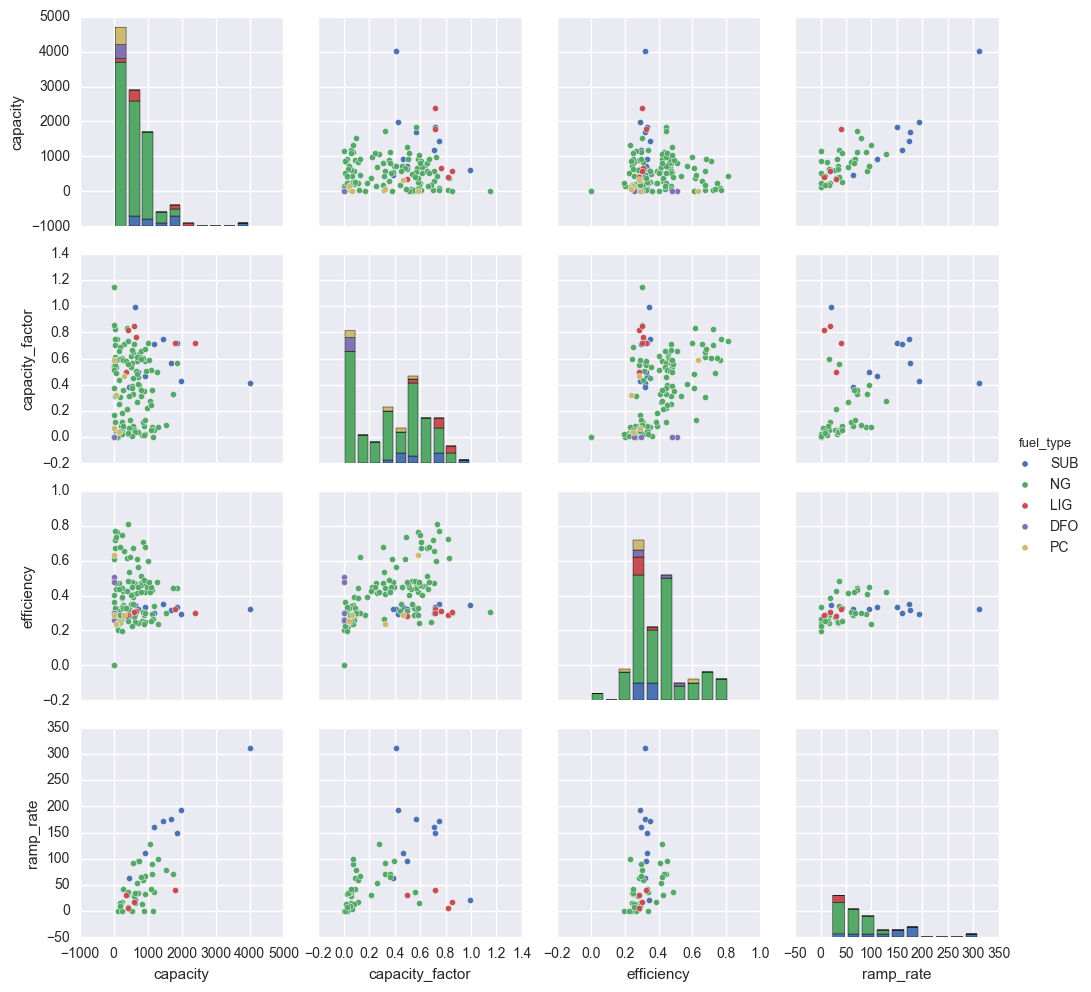

In [69]:
sns.pairplot(clusterDict[2012], hue='fuel_type', vars=['capacity', 'capacity_factor', 'efficiency', 'ramp_rate'])

In [43]:
for key in clusterDict.keys():
    print key, clusterDict[key].plant_id.count(), clusterDict[key].ramp_rate.count()

2007 143 52
2008 139 52
2009 138 49
2010 139 50
2011 135 50
2012 139 50
2013 141 50
2014 140 51
2015 139 52


#### Save dictionary to csv and load as a DataFrame to avoid pre-processing again

In [44]:
# re-arrange column order
columns = ['year', 'plant_id', 'capacity', 'capacity_factor', 'efficiency', 'ramp_rate', 'fuel_type']

filename = 'Cluster_Data_121216.csv'
fullpath = os.path.join(filename)

counter = 0
for key, df in clusterDict.iteritems():
    # create the csv file
    if counter == 0:
        df[columns].sort_values(by='plant_id').to_csv(fullpath, sep=',',  index = False)
        counter += 1
    # append to existing csv file
    else:
        df[columns].sort_values(by='plant_id').to_csv(fullpath, sep=',',  index = False, header=False, mode = 'a')

## Clustering
The number of possible clusters can range from k=1 to k=n, where n is the number of power plants operating. The point of clustering power plants is to improve our ability to predict how a group of similar power plants will increase or decrease their generation in response to changes in grid conditions. This will be especially important when using the model to predict the behavior of power plants that have not yet been built. Reducing k improves our ability to predict changes in generation, but it reduces the usefulness of the model. When k=1, we can conclude (unhelpfully) that power plants will respond to meet changes in load. Ideally, we want to find a value of k that is small enough to improve predictions but large enough to differentiate power plants into helpful groups. Future work that focuses on predicting emissions from changes in generation might use a more specific loss function related to error or uncertainty in those predictions. 

This section uses the class `Clusters`, which is defined in `cluster.py`.

In [47]:
from cluster_kplus import Clusters

Right now `Clusters` reads the data in from a file.

In [48]:
# filename = 'Cluster_Data.csv'
filename = 'Cluster_Data_121216.csv'
# path = '../Clean data'
fullpath = os.path.join(filename)

cluster = Clusters(fullpath)

In [91]:
cluster.fossil_with_ramp.describe()

,year,plant_id,capacity,capacity_factor,efficiency,ramp_rate
count,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000
mean,2010.993407,10808.582418,854.983956,0.296249,0.317737,55.461538
std,2.605898,16975.156651,658.089528,0.294650,0.072259,57.977800
min,2007.000000,127.000000,71.000000,0.000001,0.001694,0.000000
25%,2009.000000,3491.000000,418.000000,0.041708,0.273566,10.000000
50%,2011.000000,3613.000000,713.400000,0.159910,0.303370,36.000000
75%,2013.000000,6243.000000,1135.200000,0.554583,0.339298,85.000000
max,2015.000000,56674.000000,4008.400000,1.009759,0.678327,373.000000


The `make_clusters()` function uses KMeans from scikit-learn to produce clusters across a range of k-values.

In [50]:
cluster.make_clusters(n_clusters=range(5,15))

`evaluate_clusters()` calculates and plots the [calinski-harabaz](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.calinski_harabaz_score.html) score and [silhouette score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html#sklearn.metrics.silhouette_score) for each k value

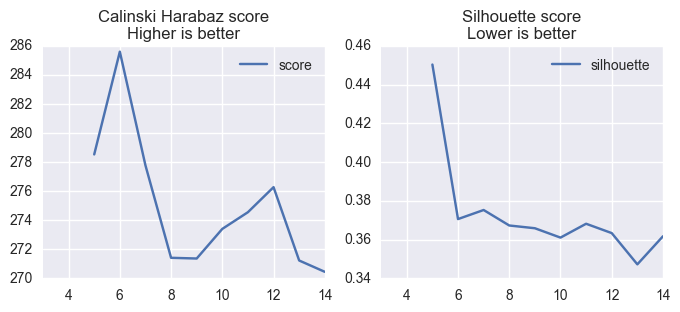

In [51]:
cluster.evaluate_clusters()

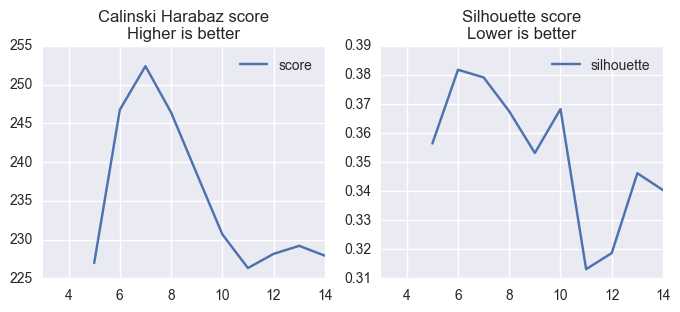

In [67]:
cluster.evaluate_clusters()

From the figures above, it is difficult to determine an optimal number of clusters. The silhouette score clearly shows that we need more than 5 clusters. 6 looks like a good number, but we also look at other options. We are most concerned with how the power plants in a cluster change their generation in response to a change in ERCOT net load. Plots with these two variables for k=6 and k=10 are included below. The net change in load from the previous hour is on the x-axis, and change in total generation from the clustered power plants is on the y-axis. Each row represents all hours of operation for a single cluster of power plants in 2007, 2011, and 2015. We do not include plots for other k values because they are large and do not add additional information. 

In both of the cluster plots, there is always one cluster that looks like it should have two independent regression lines (cluster 1 with k=7, cluster 10 with k=12). Future work can determine if these are separate plants, or plants that operate under two different modes. Either way, we expect that predictions of behavior for this group may suffer if our model doesn’t include the features that lead to this behavior. 

In [53]:
labeled_plants = cluster.label_and_export(k=6)

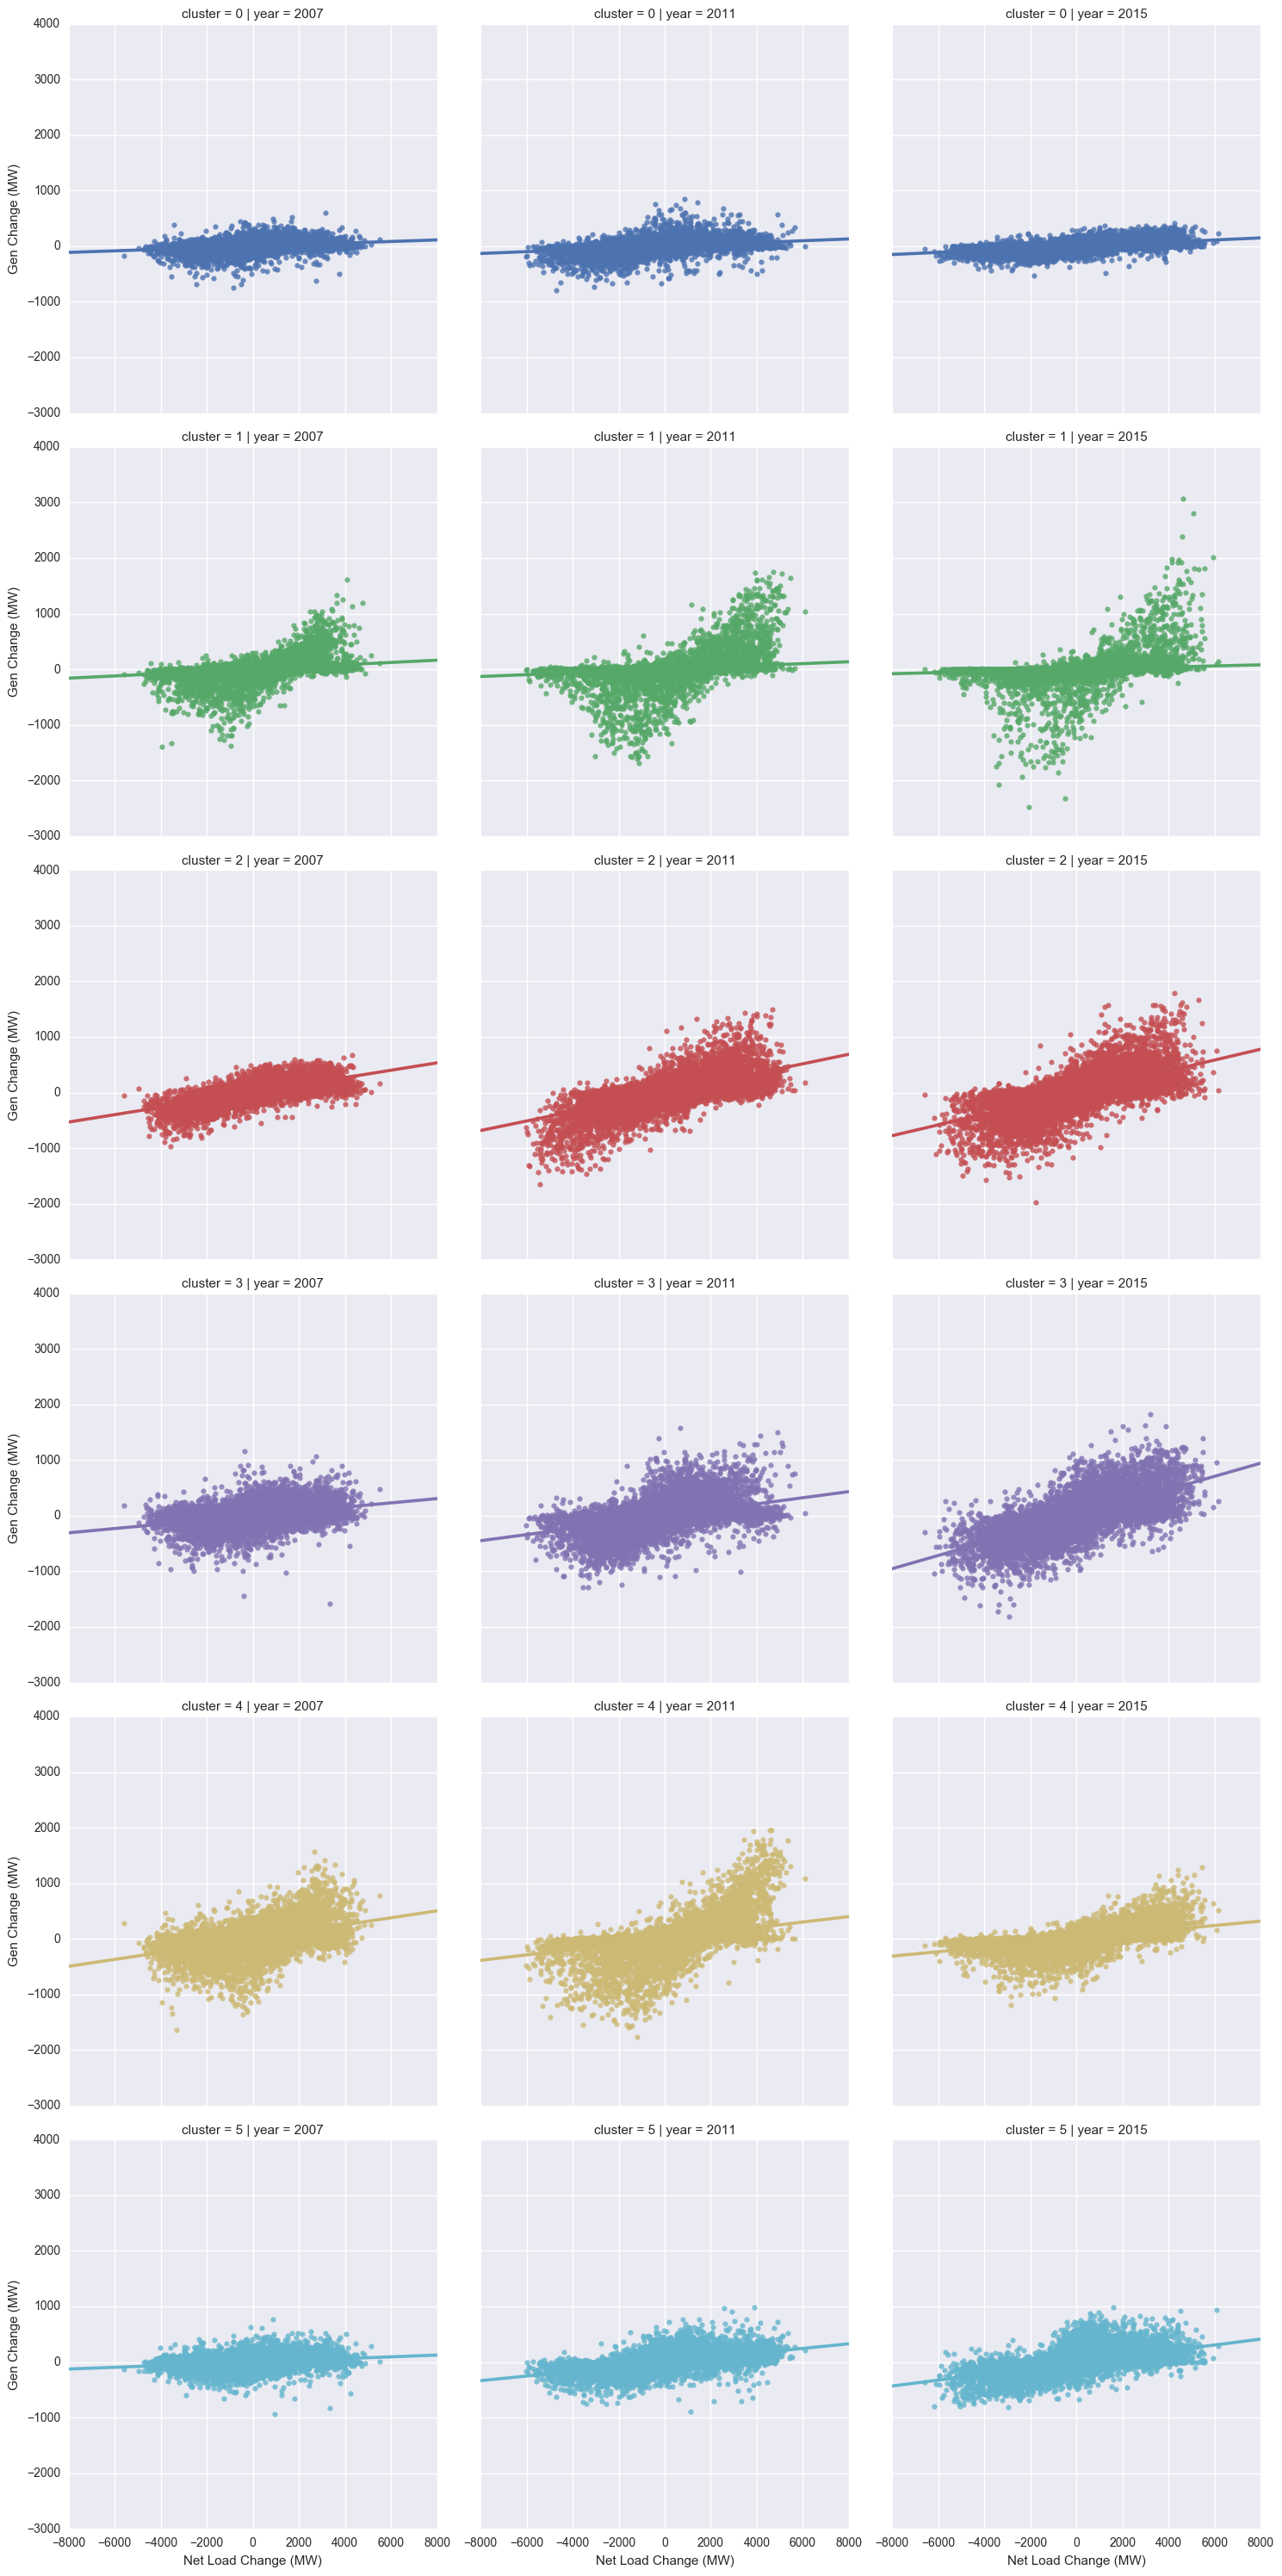

In [54]:
cluster.plot_clusters(ercot, allEPA, labeled_plants)

In [55]:
labeled_plants = cluster.label_and_export(k=12)

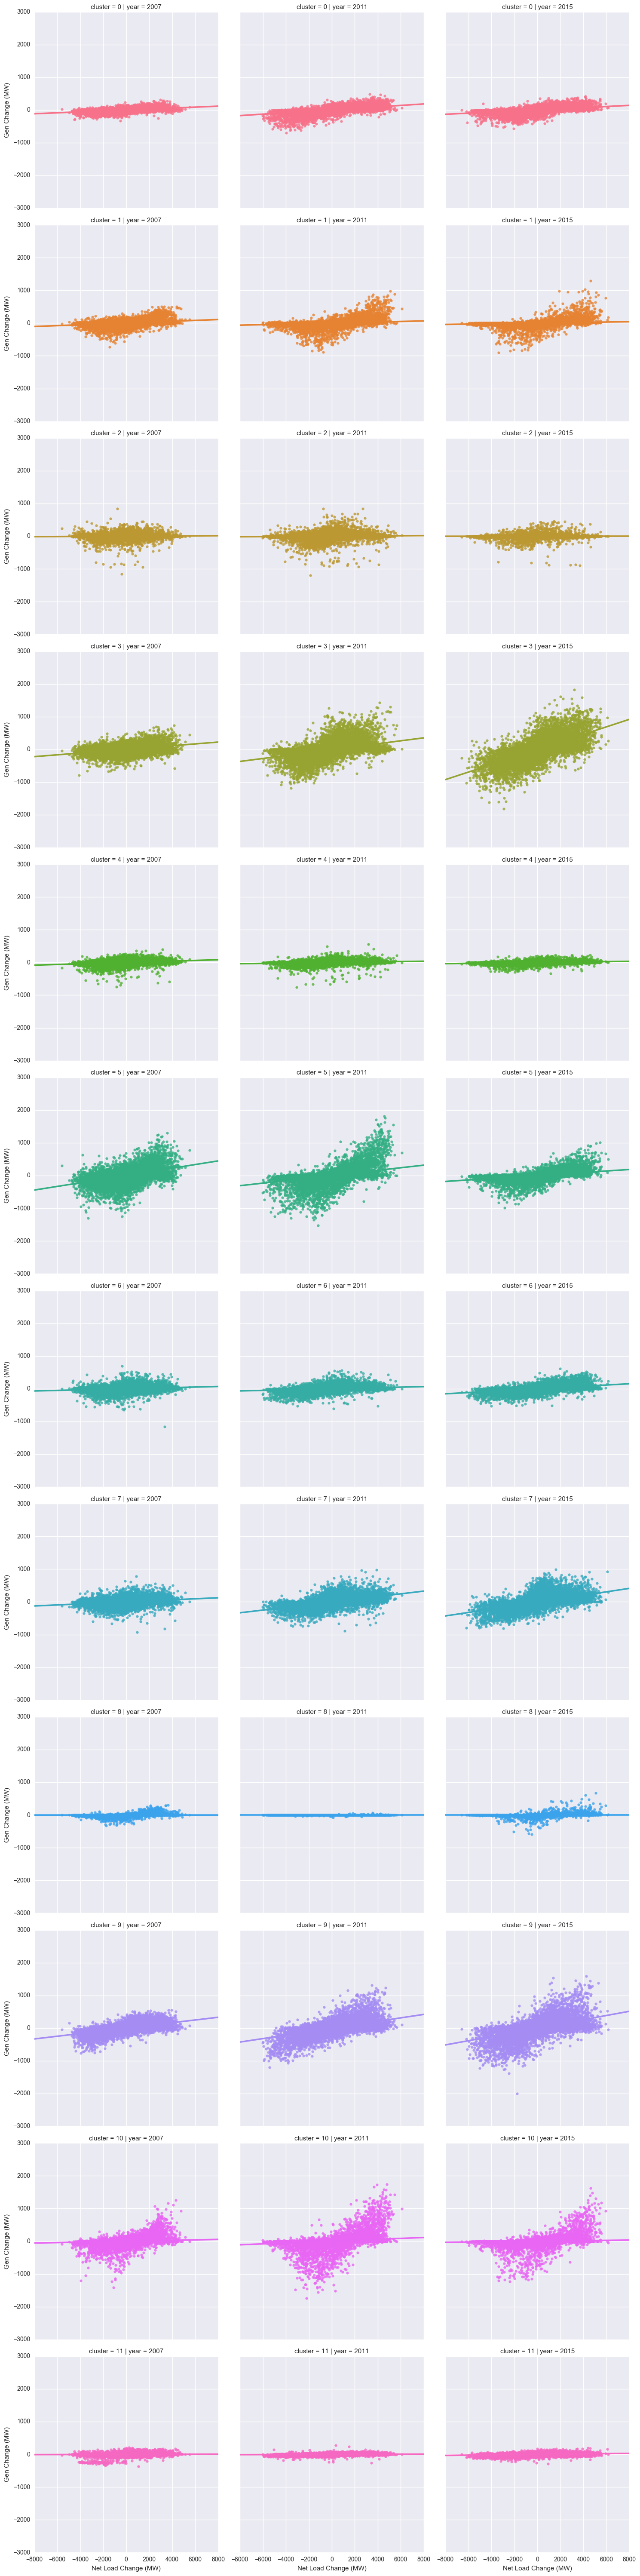

In [56]:
cluster.plot_clusters(ercot, allEPA, labeled_plants)

## Merge data for model
Now that we have imported/cleaned all of our data, put it on an hourly basis, selected an appropriate value of k for clustering power plants into groups, and labeled each plant, we can calculate the change in generation for each cluster. This historical change in generation will serve as the known y-vector for our model.

In [57]:
from MarginalUnit import Marginal_Unit

In [60]:
margUnit = Marginal_Unit(ercot, allEPA, labeled_plants, eia860Dict, fuel_price)

In [61]:
X = margUnit.getX()
y = margUnit.getY()

Save dataframes to csv

In [62]:
x_fn = 'x_121216.csv'
y_fn = 'y_121216.csv'
x_path = os.path.join(x_fn)
y_path = os.path.join(y_fn)

X.to_csv(x_path, index=None)
y.to_csv(y_path, index=None)

In [ ]:
#Load dataframes from csv

X = pd.read_csv(x_path)
y = pd.read_csv(y_path)

Description of each column used in X:
- nameplate_capacity: The total generating capacity of the cluster, calculated using data from EIA-860
- GROSS LOAD (MW): The gross amount of generation for a cluster in an hour, calculated from EPA data
- ERCOT Load, MW: The total load demanded by ERCOT in an hour, direct from ERCOT data
- Total Wind Installed, MW: The total installed wind capacity, direct from ERCOT data
- Total Wind Output, MW: The total wind output in an hour, direct from ERCOT data
- Net Load Change (MW): The net change in ERCOT load demanded from the previous hour, calculated using the change in ERCOT load and change in wind output
- NG Price (\$/mcf): The monthly price of natural gas to power plants in Texas as reported by EIA
- All coal: The quarterly price of all coal shipments (\$/short ton) to power plants in Texas as reported by EIA
- Lignite: The quarterly price of lignite coal shipments (\$/short ton) to power plants in Texas as reported by EIA
- Subbituminous: The quarterly price of subbituminous coal shipments (\$/short ton) to power plants in Texas as reported by EIA

In [72]:
X.tail()

,cluster,Year,nameplate_capacity,DATETIME,GROSS LOAD (MW),"ERCOT Load, MW","Total Wind Installed, MW","Total Wind Output, MW","Wind Output, % of Installed","Wind Output, % of Load",1-hr MW change,1-hr % change,Net Load (MW),Net Load Change (MW),Month,NG Price ($/mcf),All coal,Lignite,Subbituminous
552218,6,2015,7439.8,2015-12-31 19:00:00,769.0,39908.77734,16170.0,3824.932373,23.654498,9.584188,483.971191,14.485987,36083.844967,-1172.357911,12,2.23,28.53,24.04,32.55
552219,6,2015,7439.8,2015-12-31 20:00:00,597.0,38736.85938,16170.0,4625.632813,28.606264,11.941166,800.700440,20.933715,34111.226567,-1972.618400,12,2.23,28.53,24.04,32.55
552220,6,2015,7439.8,2015-12-31 21:00:00,560.0,37587.70313,16170.0,4957.714844,30.659956,13.189725,332.082031,7.179170,32629.988286,-1481.238281,12,2.23,28.53,24.04,32.55
552221,6,2015,7439.8,2015-12-31 22:00:00,568.0,36356.26172,16170.0,4699.097656,29.060592,12.925140,-258.617188,-5.216460,31657.164064,-972.824222,12,2.23,28.53,24.04,32.55
552222,6,2015,7439.8,2015-12-31 23:00:00,658.0,35150.33984,16170.0,4313.125000,26.673624,12.270507,-385.972656,-8.213761,30837.214840,-819.949224,12,2.23,28.53,24.04,32.55


In [73]:
y.tail()

,DATETIME,cluster,Gen Change (MW)
552218,2015-12-31 19:00:00,6,-24.0
552219,2015-12-31 20:00:00,6,-172.0
552220,2015-12-31 21:00:00,6,-37.0
552221,2015-12-31 22:00:00,6,8.0
552222,2015-12-31 23:00:00,6,90.0


## Model training

#### Ratio of prices
Because the coal and natural gas prices provided by EIA are nominal, they are not appropriate to use in modeling future scenarios. Rather than adjusting for inflation - which is also difficult to anticipate for the future - we divide the coal prices by the price of natural gas. This ratio of prices contains all the same information, but is invariant to inflationary effects.

In [74]:
for fuel in ['All coal', 'Lignite', 'Subbituminous']:
    X.loc[:,fuel] = X.loc[:,fuel].values/X.loc[:,'NG Price ($/mcf)'].values
    
X.drop('NG Price ($/mcf)', axis=1, inplace=True)

####  One-hot encoding of the cluster variable
The “cluster” column contains a value from 0 to 5 for each row. These cluster values are transformed into boolean variables (0 or 1) through one-hot encoding.

In [75]:
cluster_ids = X['cluster'].unique()
for cluster_id in cluster_ids:
    X['cluster_{}'.format(cluster_id)] = np.eye(len(cluster_ids))[X['cluster'],cluster_id]

In [76]:
# Drop unnecessary columns and replace nan's with 0

X_cols = ['nameplate_capacity', 'GROSS LOAD (MW)', 'ERCOT Load, MW',
          'Total Wind Installed, MW', 'Total Wind Output, MW', 'Net Load Change (MW)',
          'NG Price ($/mcf)', 'All coal', 'Lignite', 'Subbituminous']
X_cluster_cols = ['cluster_{}'.format(cluster_id) for cluster_id in cluster_ids]

X_clean = X.loc[:,X_cols+X_cluster_cols]
X_clean.fillna(0, inplace=True)

y_clean = y.loc[:,'Gen Change (MW)']
y_clean.fillna(0, inplace=True)

In [77]:
print X_clean.shape
print y_clean.shape

(552223, 17)
(552223,)


#### Split into training, validation, testing
We have 9 years (~79,000 hours) of data, representing 2009-2015. Of these 9 years, we use 5 for training (2007-2011), reserve 2 for validation (2012-2013), and 2 for final testing (2014-2015). Because most of the regression models perform better with scaled data, we also transform the data (centered at zero with unit standard deviation) using the scikit-learn StandardScaler() function.

In [78]:
X_train = X_clean.loc[(X['Year']<2012),:]
y_train = y_clean.loc[(X['Year']<2012)]

X_va = X_clean.loc[X['Year'].isin([2012, 2013]),:]
y_va = y_clean.loc[X['Year'].isin([2012, 2013])]

X_test = X_clean.loc[X['Year']>2013,:]
y_test = y_clean.loc[X['Year']>2013]

In [79]:
print X_va.shape, y_va.shape

(122808, 17) (122808,)


In [80]:
X_train_scaled = StandardScaler().fit_transform(X_train)
X_va_scaled = StandardScaler().fit_transform(X_va)
X_test_scaled = StandardScaler().fit_transform(X_test)

Check size of all arrays

In [81]:
print X_train_scaled.shape, y_train.shape
print X_va_scaled.shape, y_va.shape
print X_test_scaled.shape, y_test.shape

(306768, 17) (306768,)
(122808, 17) (122808,)
(122647, 17) (122647,)


## Linear Regression (OLS)
We start by fitting our data to a linear model that minimizes ordinary least squares loss. There are no hyperparameters to test on this type of model. According to the [scikit-learn documentation](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)[[9]](#References):

    “The.. [score] …is defined as (1 - u/v), where u is the regression sum of squares ((y_true - y_pred) ** 2).sum() and v is the residual sum of squares ((y_true - y_true.mean()) ** 2).sum(). Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). A constant model that always predicts the expected value of y, disregarding the input features, would get a R^2 score of 0.0.”

In [82]:
lm = LinearRegression()
lm.fit(X_train_scaled, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [83]:
# for kMeans k=6 clusters
lm.score(X_va_scaled, y_va)

0.26110080398708813

In [214]:
# for kMeans k=10 clusters
lm.score(X_va_scaled, y_va)

0.21157876479832882

In [84]:
y_pr = lm.predict(X_va_scaled)

After fitting a model, it is helpful to plot the predicted residuals against the predicted values. The residuals should be randomly distributed around 0, with equal error in both directions. In this plot we see that the quality of the predictions varies by cluster. Cluster 2 is especially skewed, which is not surprising given the behavior seen in the plot of generation change vs load change in the Clustering section. Some of the residual errors shown in this plot are large compared to the predicted values - they range from +/-1,000 MW change in generation over a single hour, when the predicted values are almost entirely in the range of +/-400 MW.

In [98]:
y_lm_resids = pd.DataFrame(dict(zip(['Gen Change (MW)', 'y_pr', 'cluster'],
                               [y_va.values, y_pr, X.loc[X['Year'].isin([2012, 2013]),'cluster'].values])))

y_lm_resids.loc[:,'residuals'] = y_lm_resids.loc[:,'y_pr'] - y_lm_resids.loc[:,'Gen Change (MW)']

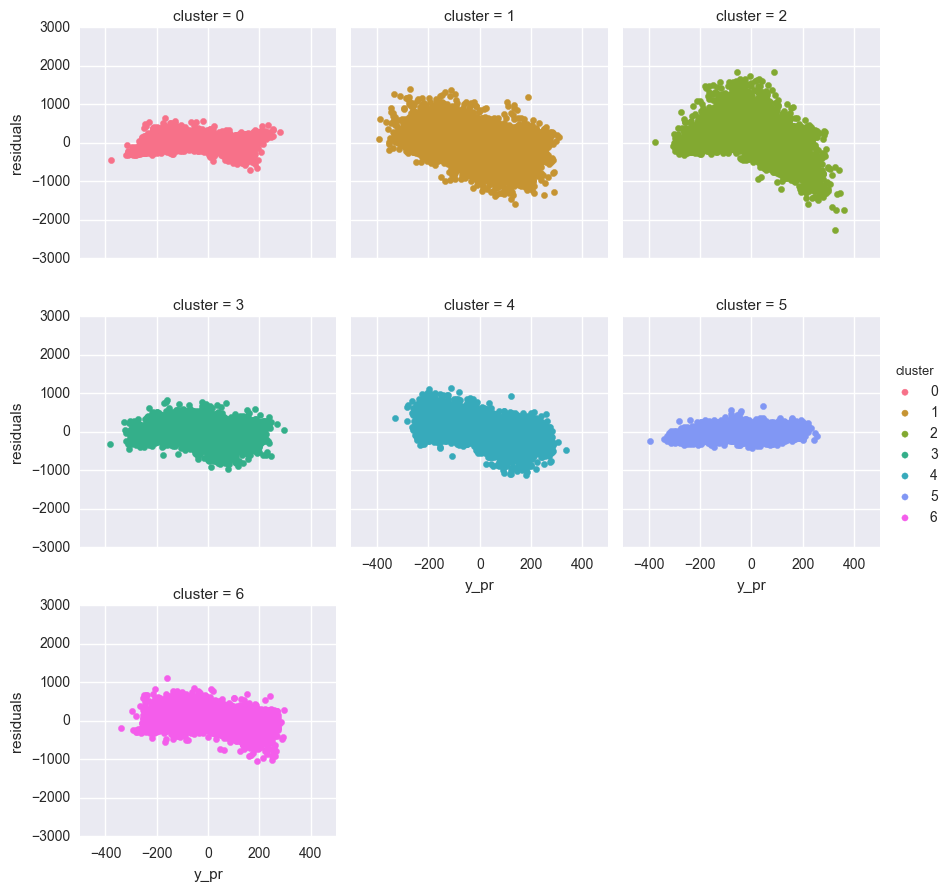

In [99]:
g = sns.FacetGrid(y_lm_resids, hue='cluster', col='cluster',
                  col_wrap=3)
g.map(plt.scatter, 'y_pr', 'residuals')
g.add_legend()

# LinearSVR
This is a linear support vector regressor, which scales to large datasets better than a SVM with a radial basis function kernel. It still employs a regularization parameter (C), which we can vary using GridSearch. From the validation curve plot below, it is apparent that the model performs poorly with small values of C (large regularization). This makes sense, because with large regularization the model will always predict the average value of y. And an average prediction of y will result in a score of 0.

In [100]:
svm = LinearSVR()

In [101]:
parameters = {'C':np.logspace(-5, 3, num=15)}

In [104]:
lm = GridSearchCV(svm, parameters, n_jobs=-1)

Run the LinearSVR with gridsearch over the 15 parameter values. GridSearchCV does 3-fold CV by default.

In [105]:
results = lm.fit(X_train_scaled, y_train)

In [106]:
results.score(X_va_scaled, y_va)

0.16512202517838237

**Validation Curve**  
[Validation curves](http://scikit-learn.org/stable/modules/learning_curve.html)[[10]](#References) are included to show how the training and cross-validation scores change as a hyperparameter is varied. For this LinearSVR model we vary "C", the regularization parameter. Low values of C correspond to a large regularization, which leads the model to predict the average value of y from the training data. High values of C can lead to over-fitting of data.

The learning curve plot shows that we get the best possible performance once 40-50% of the data is included in the model. The model does not improve beyond this point.

In [108]:
from sklearn.model_selection import validation_curve, learning_curve

In [109]:
param_range = np.logspace(-5, 3, num=15)
train_scores, valid_scores = validation_curve(LinearSVR(), X_train_scaled, y_train, "C", param_range)

(0.0, 0.2)

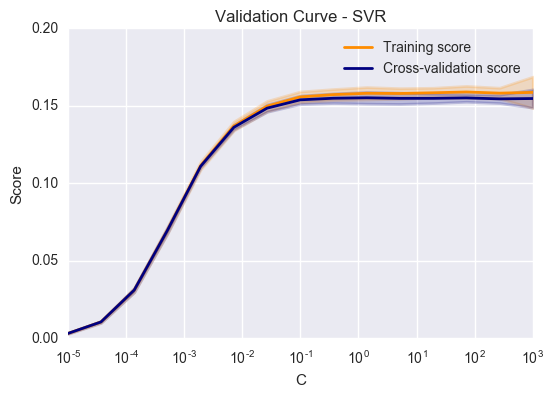

In [110]:
#http://scikit-learn.org/stable/modules/learning_curve.html
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)

plt.title("Validation Curve - SVR")
plt.xlabel("C")
plt.ylabel("Score")
plt.ylim(0.0, .2)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, valid_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, valid_scores_mean - valid_scores_std,
                 valid_scores_mean + valid_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")

**Learning Curve**
A [learning curve](http://scikit-learn.org/stable/modules/learning_curve.html)[[10]](#References) looks at how the training and cross validation score change as more data is added to the model. If there is a large gap in training and cv scores that does not close as more data is added, then the model is probably overfitting. That isn't the case here. It appers that a LinearSVR model is unlikely to give good results for our data.

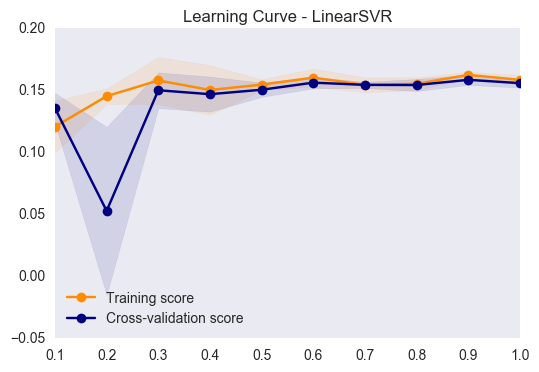

In [111]:
#http://scikit-learn.org/stable/modules/learning_curve.html
xLen = len(X_train_scaled)
tSize = [.1, .2, .3, .4, .5, .6, .7, .8, .9, 1]
train_sizes, train_scores, valid_scores = learning_curve(LinearSVR(), X_train_scaled, y_train, train_sizes = tSize)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)

plt.grid()

plt.title("Learning Curve - LinearSVR")
plt.fill_between(tSize, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="darkorange")
plt.fill_between(tSize, valid_scores_mean - valid_scores_std,
                 valid_scores_mean + valid_scores_std, alpha=0.1, color="navy")
plt.plot(tSize, train_scores_mean, 'o-', color="darkorange",
         label="Training score")
plt.plot(tSize, valid_scores_mean, 'o-', color="navy",
         label="Cross-validation score")

plt.legend(loc="best")

### SVR with rbf
We test a SVR with rbf kernel using a learning curve, because the rbf kernel computation goes with O(n^3) for large datasets. The model appears to be overfitting.

[learning_curve] Training set sizes: [17529 35059 52588 70118 87648]


[Parallel(n_jobs=-1)]: Done   4 out of  15 | elapsed:  7.0min remaining: 19.2min
[Parallel(n_jobs=-1)]: Done  10 out of  15 | elapsed: 20.1min remaining: 10.0min
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed: 42.0min finished


<function matplotlib.pyplot.show>

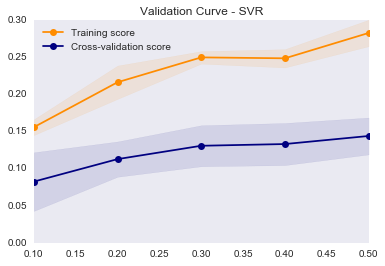

In [69]:
xLen = len(X_train_scaled)
tSize = [.1, .2, .3, .4, .5]
train_sizes, train_scores, valid_scores = learning_curve(SVR(), X_train_scaled, y_train, train_sizes = tSize, n_jobs = -1, verbose = 3)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)

plt.grid()

plt.title("Validation Curve - SVR")
plt.fill_between(tSize, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="darkorange")
plt.fill_between(tSize, valid_scores_mean - valid_scores_std,
                 valid_scores_mean + valid_scores_std, alpha=0.1, color="navy")
plt.plot(tSize, train_scores_mean, 'o-', color="darkorange",
         label="Training score")
plt.plot(tSize, valid_scores_mean, 'o-', color="navy",
         label="Cross-validation score")

plt.legend(loc="best")
plt.show

### Gradient boosted regression trees
Since none of the previous methods were able to able to predict the change in cluster generation with much accuracy, we move on to boosted gradient regression. Boosted regression trees do not require scaled data and are a very powerful tool for modeling. The code below uses the XGBoost library for learning and validation curves, which is not included in the Anaconda python distribution. The results can be matched reasonably well with GradientBoostingRegressor from scikit-learn. We use XGBoost here because it is much faster and allows us to include validation and learning curves.

In [113]:
gbr = GradientBoostingRegressor()

In [114]:
gbr.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

In [115]:
gbr.score(X_va, y_va)

0.46210852231536403

In [116]:
from xgboost import XGBRegressor

We start by looking at a validation curve for the parameter `n_estimators`

In [117]:
param_values = [50, 100, 200, 300]
train_scores, valid_scores = validation_curve(XGBRegressor(), X_train, y_train, "n_estimators", param_values,
                                              n_jobs=-1)

(0.0, 1.1)

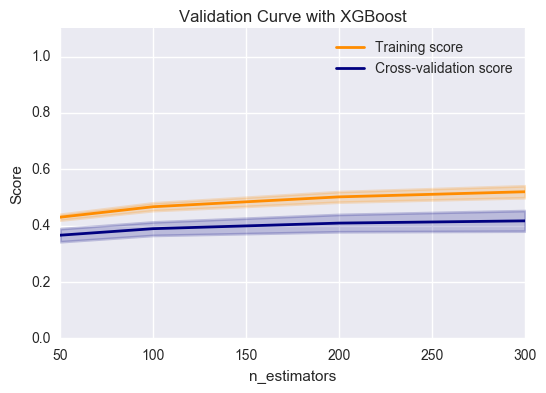

In [118]:
#http://scikit-learn.org/stable/modules/learning_curve.html
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)

plt.title("Validation Curve with XGBoost")
plt.xlabel("n_estimators")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.plot(param_values, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_values, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.plot(param_values, valid_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_values, valid_scores_mean - valid_scores_std,
                 valid_scores_mean + valid_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")

There isn't much improvement beyond 200 estimators. We will use 250 and look at the parameter `max_depth`

In [122]:
param_values = [1,3,7]
train_scores, valid_scores = validation_curve(XGBRegressor(n_estimators=250), X_train, y_train, "max_depth", param_values,
                                              n_jobs=-1)

(0.0, 1.1)

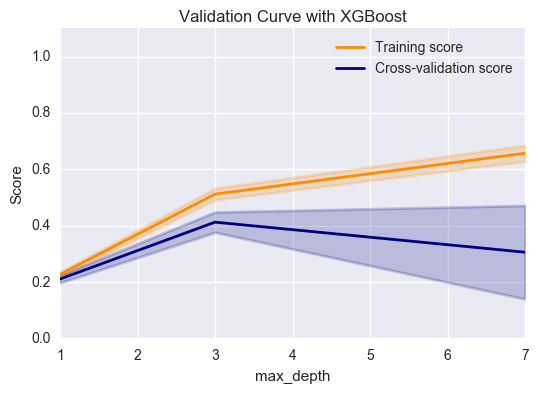

In [123]:
#http://scikit-learn.org/stable/modules/learning_curve.html
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)

plt.title("Validation Curve with XGBoost")
plt.xlabel("max_depth")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.plot(param_values, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_values, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.plot(param_values, valid_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_values, valid_scores_mean - valid_scores_std,
                 valid_scores_mean + valid_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")

Finally we look at the learning curve for XGBoost

In [124]:
train_sizes, train_scores, valid_scores = learning_curve(XGBRegressor(n_estimators=250), X_train, y_train,
                                              n_jobs=-1)

(0.0, 1.1)

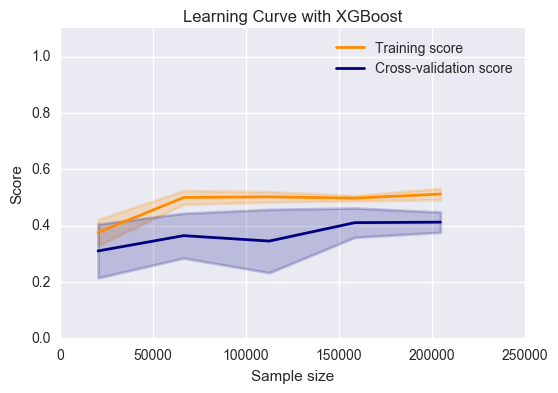

In [125]:
#http://scikit-learn.org/stable/modules/learning_curve.html
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
valid_scores_mean = np.mean(valid_scores, axis=1)
valid_scores_std = np.std(valid_scores, axis=1)

plt.title("Learning Curve with XGBoost")
plt.xlabel("Sample size")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2
plt.plot(train_sizes, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.plot(train_sizes, valid_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(train_sizes, valid_scores_mean - valid_scores_std,
                 valid_scores_mean + valid_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")

With the information from the validation and learning curves it appears more data and more features may help to improve the performance of our model.

In [126]:
gbr = GradientBoostingRegressor(n_estimators=250)

In [127]:
gbr.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=250,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

In [128]:
gbr.score(X_va, y_va)

0.49009804447528954

In [137]:
y_pr = gbr.predict(X_va)

In [140]:
y_gbr_resids = pd.DataFrame(dict(zip(['Gen Change (MW)', 'y_pr', 'cluster'],
                               [y_va.values, y_pr, X.loc[X['Year'].isin([2012, 2013]),'cluster'].values])))

y_gbr_resids.loc[:,'residuals'] = y_lm_resids.loc[:,'y_pr'] - y_lm_resids.loc[:,'Gen Change (MW)']

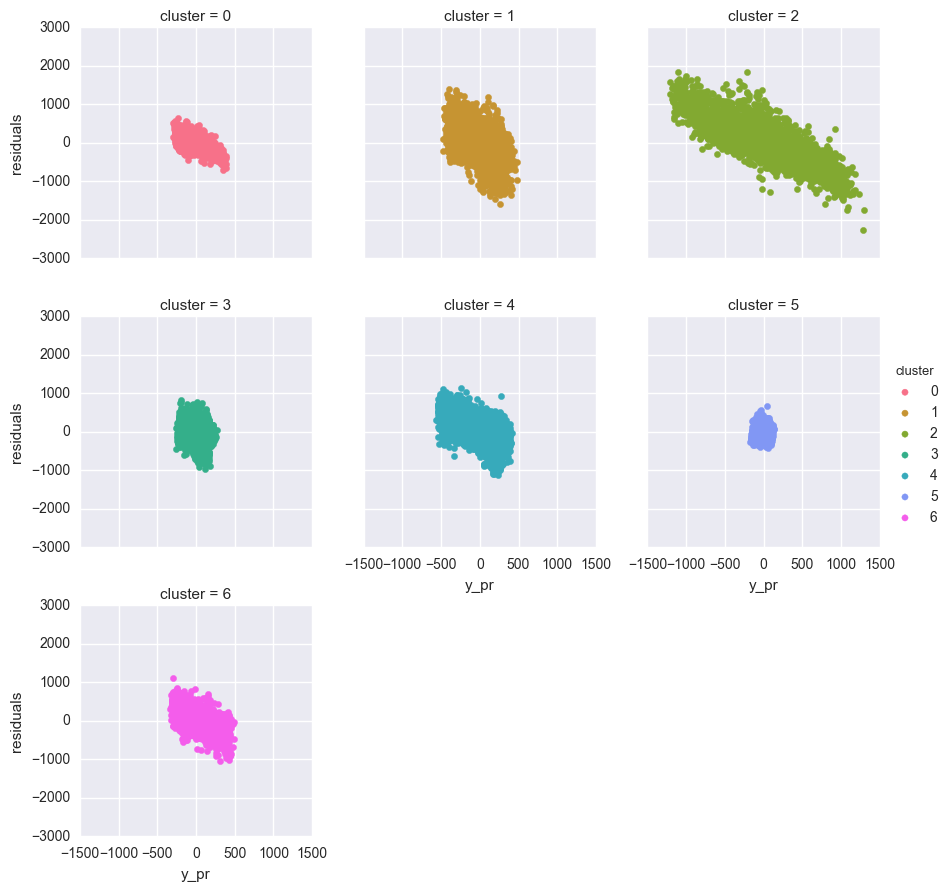

In [141]:
g = sns.FacetGrid(y_gbr_resids, hue='cluster', col='cluster',
                  col_wrap=3)
g.map(plt.scatter, 'y_pr', 'residuals')
g.add_legend()

### Final test

Finally, we fit the model with both the training and validation data and use the test hold-out set.

In [135]:
gbr.fit(np.concatenate((X_train, X_va)), np.concatenate((y_train, y_va)))

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=250,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

In [136]:
gbr.score(X_test, y_test)

0.45221472936210644

## Conclusions
This work built a gradient boosted regression tree model to predict how clusters of fossil power plants in ERCOT will change their generation in response to changes in net load. The final model captures some of the real-world behavior, but still has large errors in some predictions. Future work may include obtaining sub-hourly data for wind generation, more thoroughly exploring the clustering assignments at different levels of k, and expanding beyond ERCOT to look at a larger dataset. If the goal is to predict emissions from marginal generation, it will also be necessary to calculate the error and uncertainty in emissions from clustered power plants.

## References
1. Siler-Evans, K., Azevedo, I. L., & Morgan, M. G. (2012). Marginal Emissions Factors for the U.S. Electricity System. Environmental Science & Technology, 46(9), 4742–4748.
2. Graff Zivin, J. S., Kotchen, M. J. & Mansur, E. T. Spatial and temporal heterogeneity of marginal emissions: Implications for electric cars and other electricity-shifting policies. Journal of Economic Behavior & Organization 107, Part A, 248–268 (2014).
3. http://www.ercot.com/gridinfo/generation
4. https://www.eia.gov/electricity/data/eia923/
5. https://www.eia.gov/electricity/data/eia860/
6. http://www.eia.gov/dnav/ng/hist/n3045tx3m.htm
7. [EIA Coal Data Browser](http://www.eia.gov/beta/coal/data/browser/#/topic/45?agg=1,0&geo=vvvvvvvvvvvvo&rank=l&linechart=~~COAL.SHIP_PLANT_PRICE.TX-LIG.Q~COAL.SHIP_PLANT_PRICE.TX-SUB.Q&columnchart=COAL.SHIP_PLANT_PRICE.US-TOT.Q&map=COAL.SHIP_PLANT_PRICE.US-TOT.Q&freq=Q&start=200801&end=201601&chartindexed=0&ctype=linechart&ltype=pin&rtype=s&maptype=0&rse=0&pin=)
8. https://ampd.epa.gov/ampd/
9. http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
10. http://scikit-learn.org/stable/modules/learning_curve.html